In [170]:
import matplotlib.pyplot as plt    
import numpy as np                 
import time
import random
import math       

In [171]:
class LIF():
    def __init__(self, I, T=100, steps=0.1, n_type=1,
    v_threshold=-45, v_rest=-70, v_init=-80, v_reset=-65, v_spike=5, g_L=10, tau_m=20, delta_T=1, theta_r_h=-55, a=0.01, b=0.5, tau_w=1):

        self.v_t = []
        self.n_type = n_type
        self.fire_counter = 0
        
        self.v = v_init
        self.v_init= v_init 
        self.v_threshold = v_threshold 
        self.v_rest = v_rest 
        self.v_reset = v_reset
        self.v_spike = v_spike
        
        self.g_L = g_L 
        
        self.tau_m = tau_m 
        self.tau_w = tau_w
        
        self.T = T 
        self.I = I
        
        self.steps = steps

    def start(self):
        t = 0
        while t <= self.T:
            
            dv = (-(self.v - self.v_rest) + self.I(t) * self.g_L)* (self.steps/self.tau_m)
            self.v += dv * self.steps
            
            if self.n_type == -1:
                print(self.v)
            spiked = False
            
            if self.v >= self.v_threshold:
                self.v_t.append(self.v + self.v_spike)
                self.fire_counter += 1
                self.v = self.v_reset
                spiked = True
                
            else:
                self.v_t.append(self.v)
            t += self.steps

            yield {'u': self.v, 'spiked': spiked}

    def v_t_plot(self):
        
        plt.plot(list(map(lambda i: i * self.steps, range(len(self.v_t)))), self.v_t)
        plt.show()
        
        self.a

In [172]:
class STDP:
    def __init__(self, neurons, connections, weights, delay=1, iterations=1000):
        
        self.neurons = neurons
        self.neuron_action = []
        
        for lif in neurons:
            self.neuron_action.append(lif.start())
        
        
        self.weights = weights
        self.connections = connections
        self.iterations = iterations
        
        self.spikes = []
        self.spikes_time = []
        self.delay = delay
        self.effects_of_spikes = []
        self.time_range = []
        
        self.w_t = [[0] * self.iterations for _ in range(len(connections))]
        
    def start(self):
        
        self.effects_of_spikes = [[0] * len(self.neurons) for _ in range(self.iterations)]
        
        for t in range(self.iterations):
            self.time_range.append(t)
            
            
            for i in range(len(self.neuron_action)):
                
                action_information = next(self.neuron_action[i])
                
                if action_information['spiked']:
                    
                    self.spikes.append(i+1)
                    self.spikes_time.append(t)
                    index = 0
                    
                    for connection in self.connections:
                        
                        if connection[0] == i+1:
                            
                            if t+self.delay < self.iterations:
                                
                                self.effects_of_spikes[t + self.delay][connection[1]-1] += self.weights[index]

                            spike_index = len(self.spikes)-1
                            
                            for spike in reversed(self.spikes):
                                
                                if spike == connection[1]:
                                    
                                    t_post_minus_t_previous = self.spikes_time[spike_index] - t
                                    self.weights[index] = self.weights[index] + 25*math.exp(-abs(t_post_minus_t_previous)/5)
                                    break
                                    
                                spike_index -= 1

                        elif connection[1] == i+1:
                            
                            for spike in reversed(self.spikes):
                                
                                if spike == connection[0]:
                                    
                                    t_post_minus_t_previous = t - self.spikes_time[spike_index]
                                    self.weights[index] = self.weights[index] - 25*math.exp(-abs(t_post_minus_t_previous)/5)
                                    break
                        index += 1

                connection_index = 0
                
                for weight in self.weights:
                    
                    self.w_t[connection_index][t] = self.weights[connection_index]
                    connection_index += 1

            for i in range(len(self.neurons)):
                
                self.neurons[i].v += self.effects_of_spikes[t][i]
                
        print(self.weights)
      
    
    def u_plot(self):
        
        legend = []
        
        for i in range(len(self.neurons)):
            
            plt.plot(list(map(lambda j: j * self.neurons[i].steps, range(len(self.neurons[i].v_t)))), self.neurons[i].v_t)
            legend.append('Neuron ' + str(i+1))
            
        plt.legend(legend)
        
    def scatter_plot(self):
        
        plt.scatter(self.spikes_time, self.spikes, color='red', s=5)
        
    def wt_plot(self, previous, post):
        
        i = 0
        for connection in self.connections:
            
            if connection[0] == previous and connection[1] == post:
                break
                
            i += 1
            
        plt.plot(self.time_range, self.w_t[i], color='red')

In [173]:
I1 = lambda x: 70
I2 = lambda x: 30
I3 = lambda x: 50

first_neuron = LIF(I=I1)
second_neuron = LIF(I=I2)
third_neuron = LIF(I=I3)

neurons = [first_neuron, second_neuron, third_neuron]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [4, 4, 4, 4, 4, 4]

In [174]:
stdp = STDP(neurons, connections, weights)
stdp.start()

[2501.0016304391957, -20.748683318009704, 2540.6230770947004, 4.061968804521233, 3.954426994235204, 3.938031195478767]


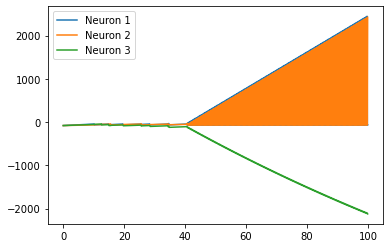

In [175]:
stdp.u_plot()

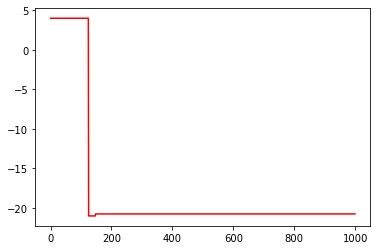

In [176]:
stdp.wt_plot(1, 3)

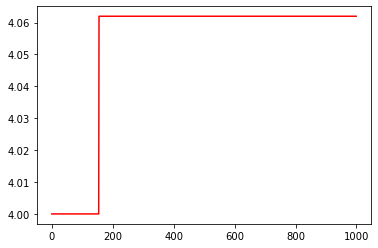

In [177]:
stdp.wt_plot(2, 3)

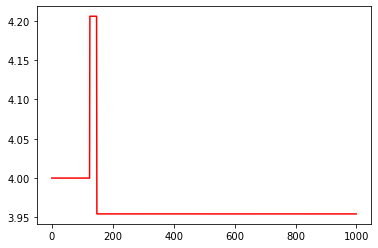

In [178]:
stdp.wt_plot(3, 1)

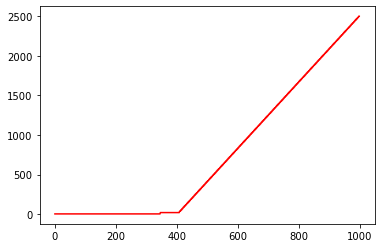

In [179]:
stdp.wt_plot(1, 2)

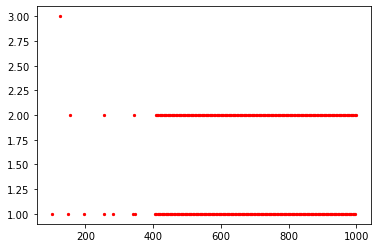

In [180]:
stdp.scatter_plot()

In [208]:
I1 = lambda x: 30 * (math.sin(x/10) + 0.6)
I2 = lambda x: 40 * (math.sin(x/10) + 0.3)
I3 = lambda x: 50 * (math.cos(x/10) + 0.9)

first_neuron = LIF(I=I1)
second_neuron = LIF(I=I2)
third_neuron = LIF(I=I3)

neurons = [neuron1, neuron2, neuron3]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [4, 4, 4, 4, 4, 4]

In [209]:
stdp = STDP(neurons, connections, weights)
stdp.start()

[-681.2392491024702, -664.5554503367952, -12.735204239717357, 374.49133879021025, -1.4752971668401471, 28.983347760652585]


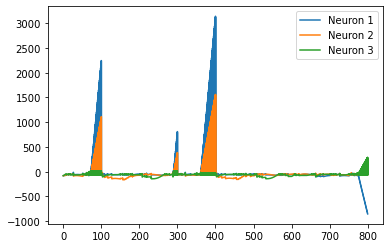

In [210]:
stdp.u_plot()

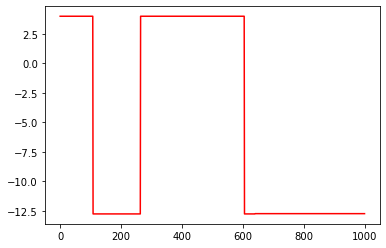

In [211]:
stdp.wt_plot(2, 1)

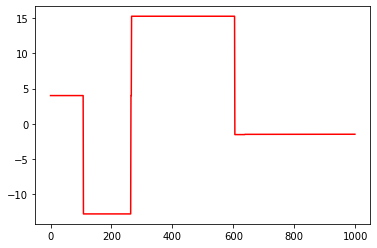

In [212]:
stdp.wt_plot(3, 1)

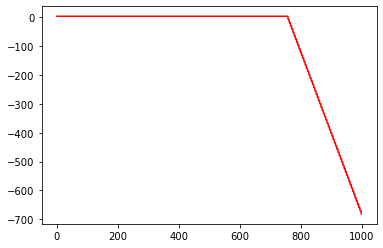

In [213]:
stdp.wt_plot(1, 2)

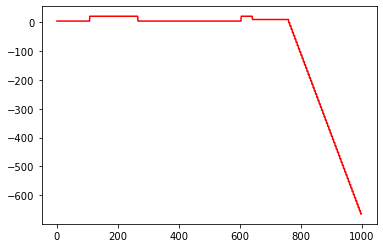

In [214]:
stdp.wt_plot(1, 3)

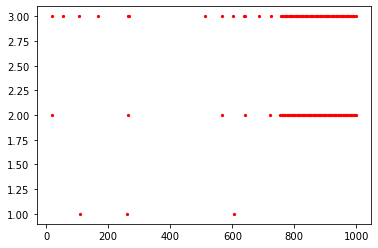

In [215]:
stdp.scatter_plot()

In [216]:
I1 = lambda x: 6 * x
I2 = lambda x: 4 * x
I3 = lambda x: 3 * x

first_neuron = LIF(I=I1)
second_neuron = LIF(I=I2)
third_neuron = LIF(I=I3)

neurons = [first_neuron, second_neuron, third_neuron]
connections = [(1, 2), (1, 3), (2, 1), (2, 3), (3, 1), (3, 2)]
weights = [4, 4, 4, 4, 4, 4]

In [217]:
stdp = STDP(neurons, connections, weights)
stdp.start()

[-16.852208424322008, -20.861742477698762, -20.8869616286854, -21.0, 20.619743628589745, 6.770078959058347]


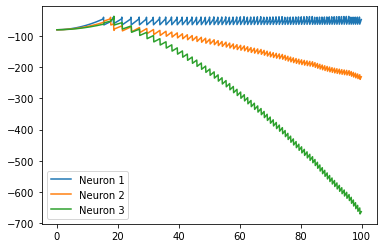

In [218]:
stdp.u_plot()

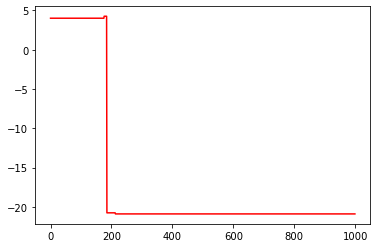

In [219]:
stdp.wt_plot(2, 1)

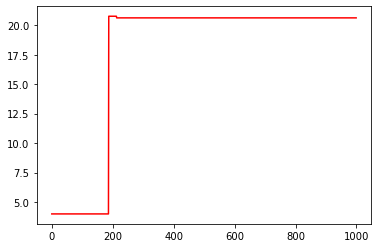

In [220]:
stdp.wt_plot(3, 1)

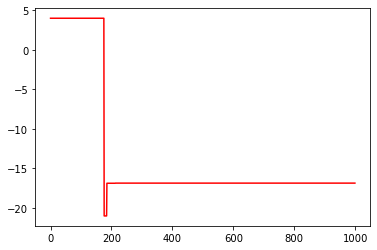

In [221]:
stdp.wt_plot(1, 2)

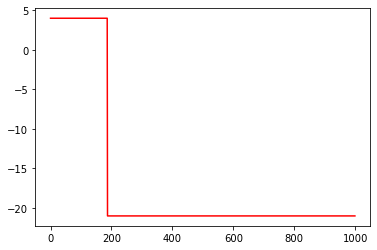

In [222]:
stdp.wt_plot(2, 3)

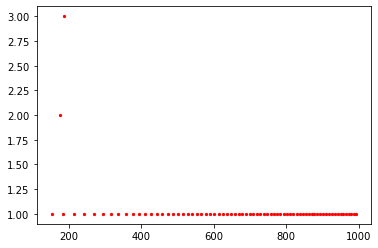

In [223]:
stdp.scatter_plot()

In [197]:
class RSTDP:
    def __init__(self, neurons, connections, weights ,output, target_neuron, mode='tr', delay=1, iterations=1000):
        
        self.neurons = neurons
        self.output = output
        self.target_neuron = target_neuron
        self.mode = mode
        self.neroun_action = []
        
        for i in neurons:
            
            self.neroun_action.append(i.start())

        
        self.weights = weights
        self.spikes = []
        self.spikes_time = []
        self.connections = connections
        self.iterations = iterations
        self.delay = delay
        self.effects_of_spikes = []
        self.time_range = []
        
        self.w_t = [[0] * self.iterations for _ in range(len(connections))]
    
    def start(self):
        
        self.effects_of_spikes = [[0] * len(self.neurons) for _ in range(self.iterations)]
        
        for t in range(self.iterations):
            
            self.time_range.append(t)
      
            for i in range(len(self.neroun_action)):
            
                action_information = next(self.neroun_action[i])
                
                if action_information['spiked']:
                    
                    if i+1 in self.output:
                        
                        if self.mode == 'tr':
                            
                            if i+1 == self.target_neuron:
                                d = 10
                                
                            else:
                                d = 1/2
                                
                            connection_index = 0
                            
                            for weight in self.weights:
                                
                                self.weights[connection_index] *= d
                                connection_index += 1
                                
                        if self.mode == 'test':
                            
                            return self.weights, t, i+1 == self.target_neuron
                        
                    self.spikes.append(i + 1)
                    self.spikes_time.append(t)
                    
                    index = 0
                    
                    for connection in self.connections:
                        
                        if connection[0] == i+1:   
                            
                            if t+self.delay < self.iterations:
                                
                                self.effects_of_spikes[t + self.delay][connection[1]-1] += self.weights[index]
                                
                            if self.mode == 'tr':
                                
                                spike_index = len(self.spikes)-1
                                
                                for spike in reversed(self.spikes):
                                    
                                    if spike == connection[1]:
                                        
                                        t_post_minus_t_previous = self.spikes_time[spike_index] - t
                                        self.weights[index] = self.weights[index] + 25*math.exp(-abs(t_post_minus_t_previous)/5)
                                        break
                                        
                                    spike_index -= 1
                                    
                        elif connection[1] == i+1:
                            
                            if self.mode == 'tr':
                                
                                for spike in reversed(self.spikes):
                                    
                                    if spike == connection[0]:
                                        
                                        t_post_minus_t_previous = t - self.spikes_time[spike_index]
                                        self.weights[index] = self.weights[index] - 25*math.exp(-abs(t_post_minus_t_previous)/5)
                                        break
                                        
                        index += 1
                        
                connection_index = 0
                
                for weight in self.weights:
                    
                    self.w_t[connection_index][t] = self.weights[connection_index]
                    connection_index += 1

            for i in range(len(self.neurons)):
                
                self.neurons[i].v += self.effects_of_spikes[t][i]

        if self.mode == 'tr':
            
            return self.weights, self.iterations
        
        else: 
            
            return self.weights, self.iterations, False

In [203]:
def train(step_number, input_currents, target_neuron, weights):
    neurons = []

    for iterator in range(5):
        
        neurons.append(LIF(I=lambda x: input_currents[iterator] * 10))
        
    for iterator in range(2):
        
        neurons.append(LIF(I=lambda x: 0))

    
    connections =  [(1, 6), (1, 7), (2, 6), (2, 7), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]
    
    if step_number == 1:
        
        weights = [15, 15, 15, 15, 15, 15, 15, 15, 15, 15]
        
    rstdp = RSTDP(neurons, connections, weights, output = [6,7], target_neuron = target_neuron + 6, mode='tr')
    weights, ending_iteration = rstdp.start()
    
    print(ending_iteration)
    return weights

def test(input_currents, target_neuron, weights):
    
    neurons = []

    for iterator in range(5):
        
        neurons.append(LIF(I=lambda x: input_currents[iterator]*10))
        
    for iterator in range(2):
        
        neurons.append(LIF(I=lambda x: 0))

        
    connections = [(1, 6), (1, 7), (2, 6), (2, 7), (3, 6), (3, 7), (4, 6), (4, 7), (5, 6), (5, 7)]

    rstdp = RSTDP(neurons, connections, weights, output = [6,7], target_neuron = target_neuron + 6, mode='test')
    weights, ending_iteration, last_spike = rstdp.start()
    
    print(ending_iteration)
    print(last_spike)
    
    return weights

In [204]:
import pandas as pd
data = pd.read_excel('./CN_3_DATASET.xlsx')
data

,test,Unnamed: 1,Unnamed: 2,Unnamed: 3,Unnamed: 4,Unnamed: 5,Unnamed: 6,Unnamed: 7,Unnamed: 8,Unnamed: 9,Unnamed: 10
0,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10
1,1.0,1.0,2.0,3.0,2.0,1.0,1.0,0.0,0.0,0.0,2.0
2,2.0,1.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,2.0
3,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0
4,4.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,1.0
5,5.0,0.0,0.0,0.0,0.0,1.0,2.0,0.0,1.0,1.0,2.0
6,output_neuron_number,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,1.0
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,test,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,inpput_neuron_number,train_1,train_2,train_3,train_4,train_5,train_6,train_7,train_8,train_9,train_10


In [205]:
train_list = [([1,1,0,0,0], 1), 
              ([2,1,1,0,0], 1), 
              ([3,1,0,0,0], 1), 
              ([2,0,0,0,0], 1), 
              ([1,1,0,0,1], 0), 
              ([1,0,0,0,2], 0), 
              ([0,1,0,3,0], 0), 
              ([0,0,0,1,1], 0), 
              ([0,0,0,0,1], 0), 
              ([2,2,2,1,2], 1)]

test_list = [([1,0,0,0,0], 1), 
             ([0,1,0,0,0], 1), 
             ([0,2,0,0,0], 1), 
             ([2,2,1,0,0], 1), 
             ([1,2,0,0,0], 1), 
             ([1,0,0,0,3], 0), 
             ([3,1,0,2,3], 0), 
             ([0,0,2,2,2], 0), 
             ([1,2,0,1,1], 1), 
             ([2,2,2,3,3], 0)]

In [206]:
weights = []

learning_step = 1

for data in train_list:
    
    weights = train(step_number = learning_step, input_currents = data[0], target_neuron = data[1], weights = weights)
    
    print(weights)
    
    learning_step += 1

1000
[-175.0, 50.0, -175.0, 50.0, -175.0, 50.0, -175.0, 50.0, -175.0, 50.0]
1000
[-1750.0, 475.0, -1750.0, 475.0, -1750.0, 475.0, -1750.0, 475.0, -1750.0, 475.0]
1000
[-17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0]
1000
[-17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0, -17500.0, 4725.0]
1000
[-8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5]
1000
[-8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5, -8750.0, 2337.5]
1000
[-4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75]
1000
[-4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75]
1000
[-4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75, -4375.0, 1143.75]
1000
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]


In [207]:
for data in test_list:
    
    weights= test(input_currents = data[0], target_neuron = data[1], weights = weights)
    
    print(weights)

1000
False
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
767
True
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
366
True
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
366
True
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
366
True
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
1000
False
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
767
False
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0]
1000
False
[-4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141250.0, -4375000.0, 1141